In [3]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32

In [4]:
def APPM_RT256():
    RT = []
    for i in range(256):
        row = []
        count = (i*60)%256
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 256:
                count -= 256
        RT.append(row)
    RT = np.array(RT)
    return RT

In [5]:
def APPM_RT64():
    RT = []
    for i in range(256):
        row = []
        count = (i*14)%64
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 64:
                count -= 64
        RT.append(row)
    RT = np.array(RT)
    return RT

In [6]:
class Queue():
    def __init__(self):
        self.q = []
        self.r = -1
    def reset(self):
        self.q = []
        self.r = -1    
    def enqueue(self,r,c):
        self.q.append((r,c))
    def dequeue(self):
        self.r += 1
        if self.r >= len(self.q):
            return False
        return self.q[self.r]

In [7]:
def BFS(RT,r,c,g,tol=None,flag=None):
    Q = Queue()
    Q.enqueue(r,c)
    F = np.full((RT.shape[0],RT.shape[1]),False,dtype=bool)
    F[r,c] = True
    while True:
        k = Q.dequeue()
        if k == False:
            break
        if RT[k[0],k[1]] == g:
            if((k[0] > tol[0] and k[0] < tol[2] and k[1] > tol[1] and k[1] < tol[3]) or (flag)):
                return k
            else:
                flag = True

        if k[0] != 0 and not F[k[0]-1,k[1]]:
            Q.enqueue(k[0]-1,k[1])
            F[k[0]-1,k[1]] = True
        if k[0] != RT.shape[0]-1 and not F[k[0]+1,k[1]]:
            Q.enqueue(k[0]+1,k[1]) 
            F[k[0]+1,k[1]] = True
        if k[1] != 0 and not F[k[0],k[1]-1]:
            Q.enqueue(k[0],k[1]-1)
            F[k[0],k[1]-1] = True
        if k[1] != RT.shape[1]-1 and not F[k[0],k[1]+1]:
            Q.enqueue(k[0],k[1]+1)  
            F[k[0],k[1]+1] = True  



In [8]:
def hashB(npArray,bits):
    return np.mod(xxh32(npArray).intdigest(), 2**bits)

In [9]:
def fold(arr,bit):
    k = B2D.Dec2Bin(arr)
    l = len(k)
    while(l > bit):
        l >>= 1
        a = k[:l]
        b = k[l:]
        k = []
        for i in range(l):
            k.append(a[i]^b[i])
    return B2D.Bin2Dec(k)

In [10]:
def rb_tol(Gray,Gray2,G1,G2):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - G1) * 0.587
    up_tol = (base + 0.5) - Gray + (G1) *0.587
    blue_low_tol = int(low_tol/0.114)
    blue_up_tol = int(up_tol/0.114)

    base2 = round(Gray2)
    low_tol = Gray2 - (base2 - 0.5) + (255 - G2) * 0.587
    up_tol = (base2 + 0.5) - Gray2 + (G2) *0.587
    blue2_low_tol = int(low_tol/0.114)
    blue2_up_tol = int(up_tol/0.114)
    
    # print(low_tol,base,Green)

    return np.array([blue_low_tol,blue2_low_tol,blue_up_tol,blue2_up_tol])


In [11]:
def limit(R,B):
    R = R >> 5
    R = R << 5
    UR = R + 31
    LR = R

    B = B >> 5
    B = B << 5
    UB = B + 31
    LB = B

    return np.array([LR,LB,UR,UB])

In [12]:
def AVGI(Graph):
    path = 'image/'+Graph
    I=io.imread(path +r'.tiff')
    Stego = I.copy()
    RT = APPM_RT256()

    p = 0
    MSE = 0
    F = 0
    N = 0

    # print(Stego.shape[0],Stego.shape[1],Stego.shape[2])

    for i in range(Stego.shape[0]):
        for j in range(0,Stego.shape[1],2):
            ac = hashB(np.array([Stego[i,j,0],Stego[i,j+1,0]]),8)
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            Gray2 = I[i,j+1,0]*0.299+I[i,j+1,1]*0.587+I[i,j+1,2]*0.114

            tol = rb_tol(Gray,Gray2,Stego[i,j,1],Stego[i,j+1,1])
            tol[0] = Stego[i,j,2] - tol[0]
            tol[1] = Stego[i,j+1,2] - tol[1]
            tol[2] += Stego[i,j,2]
            tol[3] += Stego[i,j+1,2]

            k = BFS(RT,Stego[i,j,2],Stego[i,j+1,2],ac,tol,False)
            # print(f"i: {i} j: {j} k:{k}")

            print(Stego[i,j,2],Stego[i,j+1,2],k)

            Stego[i,j,2] = k[0]
            Stego[i,j+1,2] = k[1]
            g_bar = int(round((Gray - 0.299*I[i,j,0] - 0.114*k[0])/0.587))
            g2_bar = int(round((Gray2 - 0.299*I[i,j+1,0] - 0.114*k[1])/0.587))
            if(g_bar < 0 or g_bar > 255 or g2_bar < 0 or g2_bar > 255):
                p +=1
                num = fold(ac,4)
                Stego[i,j,2] >>= 2
                Stego[i,j,2] <<= 2
                Stego[i,j,2] = Stego[i,j,2]+(num >> 2)

                Stego[i,j+1,2] >>= 2
                Stego[i,j+1,2] <<= 2
                Stego[i,j+1,2] = Stego[i,j+1,2]+(num % 4)                
                # g_bar = int(round((Gray - 0.299*Stego[i,j,0] - 0.114*Stego[i,j,2])/0.587))
                # F.append(g_bar)
                # Stego[i,j,1] = np.clip(g_bar,0,255)
            else:
                Stego[i,j,1] = g_bar
                Stego[i,j+1,1] = g2_bar

            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            MSE += delta ** 2   

            delta = int(Stego[i,j+1,2]) - int(I[i,j+1,2])
            MSE += delta ** 2
            delta = int(Stego[i,j+1,1]) - int(I[i,j+1,1])
            MSE += delta ** 2                    

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)




    # ANS = []
    # for i in range(Stego.shape[0]):
    #     for j in range(0,Stego.shape[1],2):
    #         ANS.append(RT[Stego[i,j],Stego[i,j+1]])

    # if np.all(ANS == msg):
    #     print(ANS[100],msg[100])
    # else:
    #     print("F")

In [23]:
def Authorize(Graph):
    path = "processing_image/"+Graph+".png"
    I=io.imread(path)
    Stego = I.copy()
    RT = APPM_RT256()

    Flag = False

    for i in range(Stego.shape[0]):
        if(Flag):
            break
        for j in range(0,Stego.shape[1],2):
            ac = hashB(np.array([Stego[i,j,0],Stego[i,j+1,0]]),8)
    
            if(ac == RT[Stego[i,j,2],Stego[i,j+1,2]]):
                continue
            else:
                num = fold(ac,4)
                num2 = (Stego[i,j,2] % 4)*4+(Stego[i,j+1,2] % 4)
                if(num != num2):
                    print(f"This picture is tampered. i: {i} ,j: {j} ,ac: {ac} ,RT: {RT[Stego[i,j,2],Stego[i,j+1,2]]}")
                    Flag = True
                    break
    if(not Flag):
        print("This picture is not tampered.")

              

188 157 (181, 166)
149 160 (157, 158)
152 153 (156, 148)
151 153 (145, 151)
148 154 (145, 151)
156 160 (153, 161)
156 157 (147, 157)
155 161 (160, 159)
150 153 (150, 162)
154 153 (153, 156)
157 158 (156, 167)
152 153 (156, 150)
158 155 (153, 151)
158 157 (162, 155)
152 152 (152, 149)
157 157 (165, 158)
148 152 (153, 156)
156 155 (151, 155)
159 162 (160, 166)
156 157 (156, 151)
156 160 (150, 162)
153 160 (144, 162)
159 160 (153, 156)
159 156 (159, 160)
158 157 (158, 149)
158 155 (159, 146)
156 155 (158, 158)
152 157 (157, 163)
160 159 (156, 165)
158 158 (151, 156)
157 157 (155, 165)
158 154 (151, 152)
155 151 (153, 152)
151 154 (160, 152)
154 155 (152, 150)
155 153 (157, 150)
155 154 (153, 147)
153 150 (153, 144)
155 151 (156, 158)
152 156 (151, 156)
157 153 (154, 156)
156 146 (159, 146)
151 156 (146, 161)
153 152 (153, 151)
155 157 (158, 157)
156 151 (155, 146)
157 155 (157, 150)
153 153 (158, 157)
151 152 (145, 155)
153 152 (155, 144)
152 152 (151, 152)
154 150 (155, 147)
152 155 (154

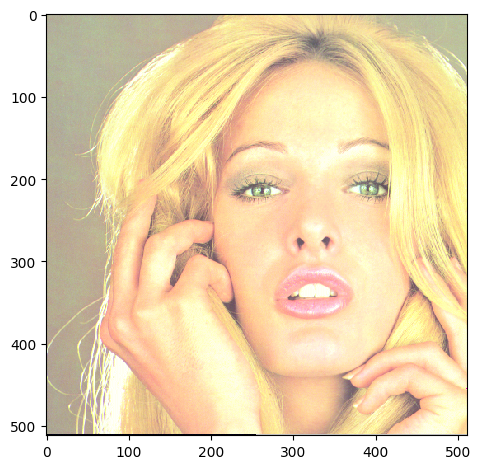

In [14]:
AVGI('Tiffany')

In [24]:
Authorize('Tiffany')

This picture is not tampered.


In [16]:
# path = 'image/'+'Tiffany'
# I=io.imread(path +r'.tiff')
# ac = hashB(np.array([I[0,1,0]//2**3,I[0,1,2]//2**3]),6)
# kk = limit(I[0,1,0],I[0,1,2])
# print(kk)
# print(I[0,1,0],I[0,1,1],I[0,1,2],I[0,1,0]//2**3,I[0,1,2]//2**3,ac)

# path = "processing_image/"+'Tiffany'+".png"
# I=io.imread(path)
# ac = hashB(np.array([I[0,1,0]//2**4,I[0,1,2]//2**4]),6)
# print(I[0,1,0],I[0,1,1],I[0,1,2],I[0,1,0]//2**3,I[0,1,2]//2**3,ac)

[160 128 191 159]
180 183 157 22 19 56
180 181 166 22 20 39
